In [1]:
import os
import pandas as pd
import joblib
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

DATAPATH = "../data"
FIGUREPATH = "../figures"
MODELPATH = "../../checkpoints/"

In [2]:
test = pd.read_csv(os.path.join(DATAPATH, "tdc_test_set.csv"))
y_test = test["outcome"]
X_test = test["smiles"]
test.head()

,smiles,inchikey,outcome
0,O=C(O)c1ccccc1O,YGSDEFSMJLZEOE-UHFFFAOYSA-N,0.0
1,CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1,SNPPWIUOZRMYNY-UHFFFAOYSA-N,0.0
2,OCC(O)C(O)C(O)C(O)CO,FBPFZTCFMRRESA-UHFFFAOYSA-N,0.0
3,CS(C)=O,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,0.0
4,CC(C)(CO)C(O)C(=O)NCCC(=O)O,GHOKWGTUZJEAQD-UHFFFAOYSA-N,0.0


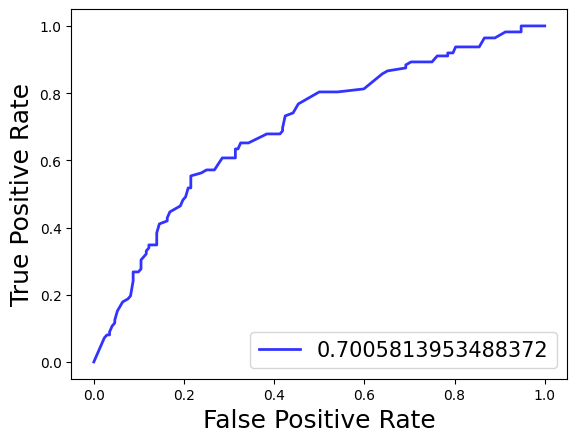

In [11]:
# Ersilia AutoML Model

mdl = joblib.load(os.path.join(MODELPATH, "ersilia_lq.joblib"))
y_pred = mdl.predict_proba(X_test.tolist())[:,1]

fpr, tpr, _ = roc_curve(y_test, y_pred)
auroc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='b', label=auroc, lw=2, alpha=.8)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.savefig(os.path.join(FIGUREPATH, "Ersilia_AutoML_validation.png"))

/home/gturon/miniconda3/envs/chem/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


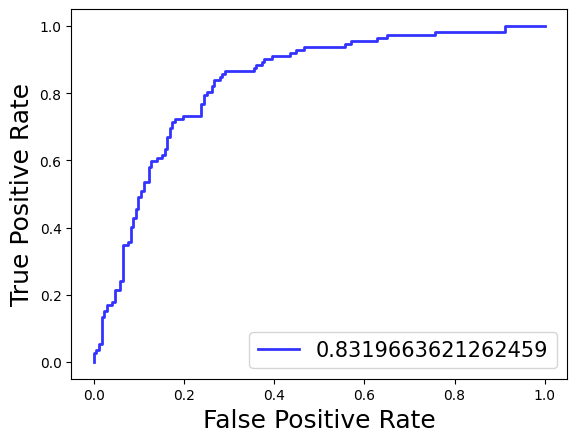

In [3]:
# Ersilia AutoGluon Model
from eosce.models import ErsiliaCompoundEmbeddings
from autogluon.tabular import TabularPredictor

mdl = TabularPredictor.load(os.path.join(MODELPATH, "ag-20240206_123841"))
eosce = ErsiliaCompoundEmbeddings()
X_test = eosce.transform(X_test)
X_test = pd.DataFrame(X_test, columns=["eosce_{}".format(i) for i in range(len(X_test[0]))])
y_pred = mdl.predict_proba(X_test, as_pandas=False)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_pred)
auroc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='b', label=auroc, lw=2, alpha=.8)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.savefig(os.path.join(FIGUREPATH, "Ersilia_AutoGluon_validation.png"))

In [ ]:
#Conversion to padel ONLY RUN ONCE
from padelpy import from_smiles

df = pd.read_csv(os.path.join(DATAPATH, "tdc_test_set.csv"))

unprocessed_idx = []
descs = []
for i,smi in enumerate(df["smiles"].tolist()):
    try:
        descriptors = from_smiles([smi])
        descs.extend(descriptors)
    except:
        print(f"Error processing SMILES: {smi}")
        unprocessed_idx += [i]

descs_df = pd.DataFrame(descs)

df_ = df.drop(unprocessed_idx)
df_padel = pd.concat([df_.reset_index(drop=True), descs_df.reset_index(drop=True)], axis=1)

#make sure all is numeric
df_padel.iloc[:, 2:] = df_padel.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')

#change infinity values
df_padel.replace([np.inf, -np.inf], 1e6, inplace=True)

#impute any missing values
for column in df_padel.columns[3:]:
    column_mean = df_padel[column].mean()
    df_padel[column].fillna(column_mean, inplace=True)

# Save the updated DataFrame to a CSV file
df_padel.to_csv(os.path.join(DATAPATH, "test_set_padel.csv"), index=False)

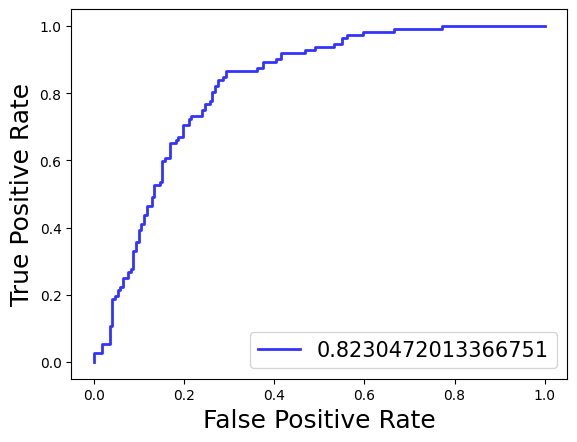

In [28]:
# Padel AutoGluon Model
from autogluon.tabular import TabularPredictor
from padelpy import from_smiles

df_padel= pd.read_csv(os.path.join(DATAPATH, "test_set_padel.csv"))

mdl = TabularPredictor.load(os.path.join(MODELPATH, "ag-20240206_133823"))
X_test = df_padel.iloc[:, 2:]
X_test = np.clip(X_test, -1e6, 1e6)

y_test = df_padel["outcome"]
y_pred = mdl.predict_proba(X_test, as_pandas=False)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_pred)
auroc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='b', label=auroc, lw=2, alpha=.8)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.savefig(os.path.join(FIGUREPATH, "Padel_AutoGluon_validation.png"))